## きのこデータ可視化


In [21]:
import os
import pandas as pd
import numpy as np
from typing import Dict, List
import importlib
from pathlib import Path
import matplotlib.pyplot as plt
import MeCab
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
import os
import yaml
import seaborn as sns
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

In [22]:
# INFO: import local libraries
import python.data_manager as dm
import python.Mecab_processing as mp
import python.util as util

In [23]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_BinaryPredictionofPoisonousMushrooms
DATA_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_BinaryPredictionofPoisonousMushrooms/data
MODEL_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_BinaryPredictionofPoisonousMushrooms/model


In [24]:
importlib.reload(util)
# ? logger読み込み
name = "MushroomsVisualization"
logger = util.set_logger()
# ? seed値固定
seed = 42
util.set_seed(seed)

2024-08-23 12:44:24,615 : python.util : INFO : 34 : Test_message


### read data


In [25]:
df = pd.read_csv(DATA_PATH / "train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [26]:
df.describe()

,id,cap-diameter,stem-height,stem-width
count,3.116945e+06,3.116941e+06,3.116945e+06,3.116945e+06
mean,1.558472e+06,6.309848e+00,6.348333e+00,1.115379e+01
std,8.997847e+05,4.657931e+00,2.699755e+00,8.095477e+00
min,0.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00
25%,7.792360e+05,3.320000e+00,4.670000e+00,4.970000e+00
50%,1.558472e+06,5.750000e+00,5.880000e+00,9.650000e+00
75%,2.337708e+06,8.240000e+00,7.410000e+00,1.563000e+01
max,3.116944e+06,8.067000e+01,8.872000e+01,1.029000e+02


In [27]:
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


### カテゴリカル変数を dammy 変換


### NaN の置換

NaN がある column :

- cap-surface
- gill-attachment
- stem-surface
- veil-type
- veil-color
- spore-print-color
- stem-root
- gill-spacing


In [28]:
# カテゴリカルな列を抽出する
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
categorical_columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

In [29]:
for col in categorical_columns:
    logger.info(f"{col}: {df[col].unique()}\n")

    if df[col].isnull().sum() > 0:
        df[col] = pd.factorize(df[col])[0] + 1
        df[col] = df[col].fillna(0).astype(int)
    else:
        df[col] = pd.factorize(df[col])[0]
df.head()

2024-08-23 12:44:28,871 : python.util : INFO : 2 : class: ['e' 'p']

2024-08-23 12:44:29,068 : python.util : INFO : 2 : cap-shape: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']

2024-08-23 12:44:29,295 : python.util : INFO : 2 : cap-surface: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'
 '1.42' 'class' 'has h' 'does None' '10.83' 'seas

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,0,8.80,1,1,1,1,1,1,1,...,0,0,1,0,0,1,1,0,1,0
1,1,1,4.51,2,2,2,1,1,1,2,...,0,1,2,0,0,2,2,0,1,1
2,2,0,6.94,1,1,3,1,2,1,1,...,0,2,3,0,0,1,1,0,2,1
3,3,0,3.88,1,3,4,1,3,0,3,...,0,0,1,0,0,1,1,0,1,2
4,4,0,5.85,2,4,5,1,4,0,1,...,0,0,1,0,0,1,1,0,3,0


In [30]:
# 欠損値のあるカテゴリカルデータをダミー変数化
# df = pd.get_dummies(df, dummy_na=True)
# df.head()

In [31]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# # profile.to_widgets()
# profile.to_file("Processed.html")

In [32]:
df.drop(columns=["id"], inplace=True)

In [33]:
# train_valid_split
from sklearn.model_selection import train_test_split

In [34]:
train, valid = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
X_train = train.drop("class", axis=1)
y_train = train["class"]
X_valid = valid.drop("class", axis=1)
y_valid = valid["class"]

In [36]:
params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "num_iterations": 200,
    "max_depth": 12,
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 42,
}
verbose_eval = 100

In [43]:
def train_kfold(df, params, verbose_eval=100):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    defscore = 0
    for i, (train_index, valid_index) in enumerate(kf.split(df)):
        train = df.iloc[train_index]
        valid = df.iloc[valid_index]
        X_train = train.drop("class", axis=1)
        y_train = train["class"]
        X_valid = valid.drop("class", axis=1)
        y_valid = valid["class"]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid)
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(verbose_eval),
            ],
        )
        # 精度が最も高いモデルを保存
        # 精度計算
        y_pred = model.predict(X_valid)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        logger.info(f"accuracy: {accuracy}, f1: {f1}")
        if f1 > defscore:
            defscore = f1
            bstmodel = model
    return bstmodel

In [44]:
model = train_kfold(df, params, verbose_eval=verbose_eval)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.983924	valid_1's auc: 0.983788
[200]	training's auc: 0.990624	valid_1's auc: 0.990561
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.990624	valid_1's auc: 0.990561


2024-08-23 12:50:52,863 : python.util : INFO : 28 : accuracy: 0.9643432912675713, f1: 0.9675167910774932
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.983613	valid_1's auc: 0.983551
[200]	training's auc: 0.990671	valid_1's auc: 0.99072
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.990671	valid_1's auc: 0.99072


2024-08-23 12:51:24,850 : python.util : INFO : 28 : accuracy: 0.9644539765700069, f1: 0.9675368340245741
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.983507	valid_1's auc: 0.983508
[200]	training's auc: 0.990773	valid_1's auc: 0.990655
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.990773	valid_1's auc: 0.990655


2024-08-23 12:51:56,492 : python.util : INFO : 28 : accuracy: 0.9641347537412435, f1: 0.9673460922803697
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.983972	valid_1's auc: 0.984089
[200]	training's auc: 0.990845	valid_1's auc: 0.990961
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.990845	valid_1's auc: 0.990961


2024-08-23 12:52:28,473 : python.util : INFO : 28 : accuracy: 0.9650827974186262, f1: 0.9681260607196567
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.983814	valid_1's auc: 0.983849
[200]	training's auc: 0.99053	valid_1's auc: 0.990485
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99053	valid_1's auc: 0.990485


2024-08-23 12:53:00,113 : python.util : INFO : 28 : accuracy: 0.9625290147885189, f1: 0.9657123145912384


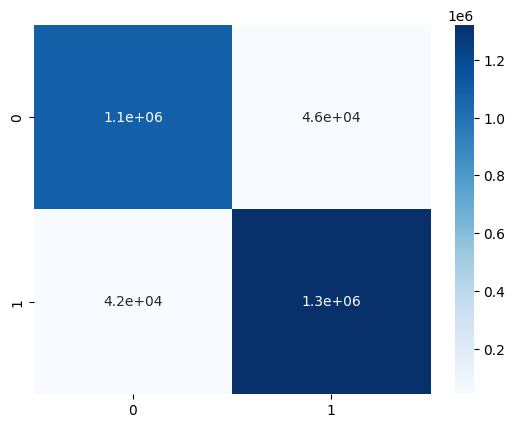

In [45]:
# trainデータでpredictして，混同行列にしてみる
y_pred = model.predict(X_train)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()


In [46]:
# categorical_columnsから"class"を削除
categorical_columns = categorical_columns.drop("class")

KeyError: "['class'] not found in axis"

In [40]:
# testデータの読み込み
test = pd.read_csv(DATA_PATH / "test.csv")
# testデータの前処理
for col in categorical_columns:
    if test[col].isnull().sum() > 0:
        test[col] = pd.factorize(test[col])[0] + 1
        test[col] = test[col].fillna(0).astype(int)
    else:
        test[col] = pd.factorize(test[col])[0]
test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,1,0,1,1,0,0,1,11.13,...,1,0,1,1,1,1,1,0,1,0
1,3116946,6.90,2,1,2,2,0,1,2,1.27,...,0,0,2,0,0,2,2,0,1,0
2,3116947,2.00,3,2,1,2,0,1,3,6.18,...,0,0,2,0,0,2,2,0,1,1
3,3116948,3.47,1,1,1,2,1,1,3,4.98,...,0,0,1,0,2,1,3,0,1,2
4,3116949,6.17,1,3,3,2,2,0,2,6.73,...,0,0,3,0,3,1,0,0,1,2


In [41]:
index = test["id"]
#
test = test.drop("id", axis=1)

In [47]:
# testデータの予測
prediction = model.predict(test, num_iteration=model.best_iteration)
prediction

array([0.43189008, 0.66817774, 0.75178001, ..., 0.27354155, 0.23346889,
       0.60632882])

In [48]:
prediction.shape

(2077964,)

In [49]:
prediction_labels = np.where(prediction >= 0.5, "p", "e")
prediction_labels.shape

(2077964,)

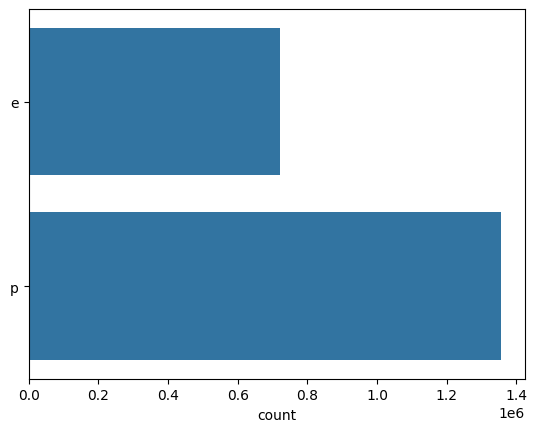

In [50]:
#test.plot
sns.countplot(prediction_labels)
plt.show()


In [ ]:
# 提出用のDataFrameを作成
submission = pd.DataFrame({"id": index, "class": prediction_labels})

In [ ]:
submission.head()

,id,class
0,3116945,p
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [ ]:
submission.to_csv(DATA_PATH / "submission.csv", index=False)

In [ ]:
import shap

# notebook内でJavascriptを動かすためのおまじない
shap.initjs()

"""
shap.TreeExplainer:決定木用(XGBoost、lightBGM等含む)
shap.LinearExplainer :線形モデル用
shap.DeepExplainer :Deeplearning用
"""
# TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
explainer = shap.Explainer(model=model)

print(explainer.expected_value)

In [ ]:
X_test_shap = X_valid.copy().reset_index(drop=True)
shap_values = explainer(X=X_test_shap)

In [ ]:
for class_idx in range(2):
    print(f"Class {class_idx} SHAP Summary Plot")
    # 特定のサンプル n に対してウォーターフォールプロットを作成
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[n, :, class_idx],
            base_values=explainer.expected_value[class_idx],
            data=X_test_shap.iloc[n, :],
            feature_names=X_test_shap.columns,
        ),
        show=False,
    )
    # waterfall plotをsvgで保存
    plt.savefig(f"waterfall_plot_{n}_{class_idx}.svg")
    plt.show()

    shap.summary_plot(shap_values[:, :, class_idx], X_test_shap)
    shap.summary_plot(
        shap_values[:, :, class_idx], X_test_shap, plot_type="bar", show=False
    )
    # plt.savefig(f"imp_plot_{n}_{class_idx}.svg")
    plt.show()